# 1. Imports & Config

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import ndarray
from matplotlib.pyplot import subplots, show
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, top_k_accuracy_score

# bias
from collections import Counter


# model building imports
import keras
from keras import Model, Sequential, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import LeakyReLU
from keras.ops import add
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC, F1Score, TopKCategoricalAccuracy
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler ,ReduceLROnPlateau, EarlyStopping
from keras.utils import Sequence, load_img, img_to_array


# image filtering 
from tensorflow.keras.applications import ResNet50, EfficientNetB6
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.utils import load_img, img_to_array
import numpy as np
from tqdm import tqdm

import keras_tuner
# augmentation operations
from keras.layers import RandomBrightness, RandomFlip, RandomRotation, RandomContrast
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from keras.layers import Pipeline
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.applications import ResNet50
from keras.applications import EfficientNetV2S
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras.initializers import Constant

In [19]:
import tensorflow as tf

# List all physical GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
print('num gpus:', len(tf.config.list_physical_devices('GPU')))

num gpus: 1


In [21]:
tf.config.run_functions_eagerly(True)

In [22]:
# importing the dataset
metadata = pd.read_csv('../rare_species 1/metadata.csv')
#metadata = pd.read_csv('../Data/rare_species/metadata.csv')
metadata.sample(5)

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
5731,b05ce9b6-0caa-413e-b5d2-9d8d616bb617,29581400,1178065,animalia,chordata,psittacidae,chordata_psittacidae/29581400_1178065_eol-full...
6241,ef831bf8-5f15-4d1d-b226-0f2d689f4fd9,28677600,1057176,animalia,chordata,dactyloidae,chordata_dactyloidae/28677600_1057176_eol-full...
6412,70f88cd5-21d8-4c34-8751-b233d299d18b,22730723,4453305,animalia,chordata,cebidae,chordata_cebidae/22730723_4453305_eol-full-siz...
5876,9cfcbbb9-b764-4f54-b1e5-292a2732267c,30094992,4453913,animalia,chordata,cercopithecidae,chordata_cercopithecidae/30094992_4453913_eol-...
3501,93d781ab-f3fd-4b75-9540-7fef2483f174,29407573,45513821,animalia,chordata,diomedeidae,chordata_diomedeidae/29407573_45513821_eol-ful...


In [23]:
# applying the filepath
metadata['file_path'] = metadata['file_path'].apply(lambda x: os.path.join('../rare_species 1', x))

In [24]:
metadata.sample(5)

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
4314,4002fe5a-9202-4275-83d9-f213b0627e02,29627747,46570656,animalia,chordata,balistidae,../rare_species 1/chordata_balistidae/29627747...
2284,ff8d7a7a-b885-435f-8785-11dc8273d8f8,29980091,46559786,animalia,chordata,carcharhinidae,../rare_species 1/chordata_carcharhinidae/2998...
1146,c0d82dc0-a6cc-4384-9b01-cf63a7fc808a,14083210,328029,animalia,chordata,mustelidae,../rare_species 1/chordata_mustelidae/14083210...
1852,39d79432-9760-433d-afdd-2a993b50150a,28475832,1057157,animalia,chordata,dactyloidae,../rare_species 1/chordata_dactyloidae/2847583...
6445,21692416-2071-4ad8-9340-b6da2aec72fa,28509771,4453305,animalia,chordata,cebidae,../rare_species 1/chordata_cebidae/28509771_44...


# 2.  Preprocessing

In [25]:
metadata.phylum.unique()

array(['mollusca', 'chordata', 'arthropoda', 'echinodermata', 'cnidaria'],
      dtype=object)

In [26]:
print(metadata['family'].value_counts())

family
dactyloidae        300
cercopithecidae    300
formicidae         291
carcharhinidae     270
salamandridae      270
                  ... 
cyprinodontidae     30
alligatoridae       30
balaenidae          30
goodeidae           30
siluridae           29
Name: count, Length: 202, dtype: int64


In [27]:
num_classes = metadata['family'].nunique()
num_classes

202

our dataset is inbalaced and has a length of 202 classes

In [28]:
# Transforming our target and feature into a int
label_encoder = LabelEncoder()
metadata['target'] = label_encoder.fit_transform(metadata['family'])


In [29]:
metadata['target'].sample(10)

9063      49
11108     60
2023      13
1261      60
3005       2
481      132
5579      66
2970     152
11025     76
11013    115
Name: target, dtype: int64

## Cheking for misslabeled images/ images that are not supposed to be in our dataset

Even with False Positives the objective is to not discard more than 10% of our dataset

In [ ]:
model = EfficientNetB6(weights="imagenet", include_top=True)

weird_samples = []

for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
    path = row['file_path']
    true_label = row['family']

    try:
        img = load_img(path, target_size=(528, 528))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        preds = model.predict(x, verbose=0)
        top_pred = decode_predictions(preds, top=1)[0][0]  # (id, label, prob)

        class_id = top_pred[0]  # e.g. 'n02124075'
        prob = top_pred[2]

        # ImageNet animals all fall into n02xxxxx
        if not class_id.startswith('n02') and prob > 0.85:
            print(f"Not animal (class_id={class_id}) → removed: labeled '{true_label}'")
            weird_samples.append((path, class_id, prob, true_label))

    except Exception as e:
        print(f"Error reading {path}: {e}")




  3%|▎         | 354/11983 [01:51<1:00:58,  3.18it/s]

Not animal (class_id=n01855672) → removed: labeled 'anatidae'


  3%|▎         | 402/11983 [02:06<1:02:51,  3.07it/s]

Not animal (class_id=n03530642) → removed: labeled 'merulinidae'


  4%|▍         | 471/11983 [02:28<1:00:02,  3.20it/s]

Not animal (class_id=n06359193) → removed: labeled 'sphyrnidae'


  5%|▌         | 622/11983 [03:18<1:00:48,  3.11it/s]

Not animal (class_id=n03794056) → removed: labeled 'cryptobranchidae'


  5%|▌         | 638/11983 [03:23<59:36,  3.17it/s]  

Not animal (class_id=n01496331) → removed: labeled 'balistidae'


  7%|▋         | 884/11983 [04:41<59:17,  3.12it/s]  

Not animal (class_id=n01917289) → removed: labeled 'faviidae'


  8%|▊         | 931/11983 [04:56<58:31,  3.15it/s]  

Not animal (class_id=n01855672) → removed: labeled 'anatidae'


 10%|▉         | 1161/11983 [06:10<57:30,  3.14it/s]  

Not animal (class_id=n01818515) → removed: labeled 'psittacidae'


 10%|█         | 1228/11983 [06:31<55:38,  3.22it/s]

Not animal (class_id=n01496331) → removed: labeled 'dasyatidae'


 11%|█         | 1292/11983 [06:51<55:58,  3.18it/s]  

Not animal (class_id=n03452741) → removed: labeled 'gavialidae'


 11%|█         | 1306/11983 [06:56<55:13,  3.22it/s]

Not animal (class_id=n01608432) → removed: labeled 'psittacidae'


 11%|█▏        | 1375/11983 [07:18<57:08,  3.09it/s]

Not animal (class_id=n01917289) → removed: labeled 'faviidae'


 12%|█▏        | 1469/11983 [07:47<56:27,  3.10it/s]

Not animal (class_id=n01910747) → removed: labeled 'hylobatidae'


 12%|█▏        | 1485/11983 [07:52<54:35,  3.21it/s]

Not animal (class_id=n01917289) → removed: labeled 'faviidae'


 13%|█▎        | 1518/11983 [08:03<55:18,  3.15it/s]

Not animal (class_id=n01534433) → removed: labeled 'estrildidae'


 13%|█▎        | 1531/11983 [08:07<54:24,  3.20it/s]

Not animal (class_id=n01667778) → removed: labeled 'emydidae'


 13%|█▎        | 1556/11983 [08:15<54:02,  3.22it/s]

Not animal (class_id=n01917289) → removed: labeled 'diploastraeidae'


 14%|█▍        | 1666/11983 [08:49<54:48,  3.14it/s]

Not animal (class_id=n04118776) → removed: labeled 'unionidae'


 14%|█▍        | 1695/11983 [08:59<54:44,  3.13it/s]

Not animal (class_id=n01883070) → removed: labeled 'vombatidae'


 14%|█▍        | 1721/11983 [09:07<59:37,  2.87it/s]  

Not animal (class_id=n01910747) → removed: labeled 'testudinidae'


 15%|█▍        | 1785/11983 [09:29<56:38,  3.00it/s]  

Not animal (class_id=n03000134) → removed: labeled 'polyprionidae'


 18%|█▊        | 2099/11983 [11:10<52:37,  3.13it/s]

Not animal (class_id=n06359193) → removed: labeled 'brachypteraciidae'


 18%|█▊        | 2163/11983 [11:31<51:50,  3.16it/s]

Not animal (class_id=n04118776) → removed: labeled 'agariciidae'


 18%|█▊        | 2190/11983 [11:39<51:18,  3.18it/s]

Not animal (class_id=n01580077) → removed: labeled 'thraupidae'


 18%|█▊        | 2208/11983 [11:45<50:44,  3.21it/s]

Not animal (class_id=n01833805) → removed: labeled 'trochilidae'


 19%|█▉        | 2266/11983 [12:03<51:45,  3.13it/s]

Not animal (class_id=n01917289) → removed: labeled 'faviidae'


 19%|█▉        | 2317/11983 [12:20<51:37,  3.12it/s]

Not animal (class_id=n01689811) → removed: labeled 'anguidae'


 20%|█▉        | 2378/11983 [12:40<52:39,  3.04it/s]

Not animal (class_id=n01855672) → removed: labeled 'anatidae'


 20%|█▉        | 2388/11983 [12:43<51:55,  3.08it/s]

Not animal (class_id=n03793489) → removed: labeled 'sparidae'


 21%|██        | 2498/11983 [13:18<49:52,  3.17it/s]

Not animal (class_id=n01917289) → removed: labeled 'faviidae'


 21%|██        | 2535/11983 [13:29<48:56,  3.22it/s]

Not animal (class_id=n01833805) → removed: labeled 'trochilidae'


 21%|██        | 2538/11983 [13:30<50:16,  3.13it/s]

Not animal (class_id=n01496331) → removed: labeled 'balistidae'


 21%|██        | 2541/11983 [13:31<50:41,  3.10it/s]

Not animal (class_id=n01616318) → removed: labeled 'accipitridae'


 23%|██▎       | 2801/11983 [14:54<47:40,  3.21it/s]

Not animal (class_id=n04118776) → removed: labeled 'arthroleptidae'


 24%|██▍       | 2862/11983 [15:13<49:02,  3.10it/s]

Not animal (class_id=n01632777) → removed: labeled 'ambystomatidae'


 25%|██▌       | 3031/11983 [16:08<47:50,  3.12it/s]  

Not animal (class_id=n01534433) → removed: labeled 'pardalotidae'


 26%|██▌       | 3064/11983 [16:19<48:04,  3.09it/s]

Not animal (class_id=n01608432) → removed: labeled 'falconidae'


 28%|██▊       | 3336/11983 [17:46<45:55,  3.14it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 29%|██▉       | 3478/11983 [18:32<45:06,  3.14it/s]

Not animal (class_id=n01689811) → removed: labeled 'anguidae'


 29%|██▉       | 3483/11983 [18:33<45:14,  3.13it/s]

Not animal (class_id=n01496331) → removed: labeled 'balistidae'


 29%|██▉       | 3511/11983 [18:42<45:41,  3.09it/s]

Not animal (class_id=n01917289) → removed: labeled 'faviidae'


 29%|██▉       | 3534/11983 [18:49<43:22,  3.25it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 30%|██▉       | 3535/11983 [18:50<44:12,  3.18it/s]

Not animal (class_id=n01632777) → removed: labeled 'ambystomatidae'


 31%|███       | 3684/11983 [19:37<43:48,  3.16it/s]

Not animal (class_id=n01632777) → removed: labeled 'ambystomatidae'


 31%|███       | 3741/11983 [19:55<42:48,  3.21it/s]

Not animal (class_id=n01917289) → removed: labeled 'agariciidae'


 33%|███▎      | 3975/11983 [21:09<42:52,  3.11it/s]

Not animal (class_id=n01494475) → removed: labeled 'alopiidae'


 33%|███▎      | 4006/11983 [21:19<41:55,  3.17it/s]

Not animal (class_id=n01496331) → removed: labeled 'dasyatidae'


 34%|███▎      | 4043/11983 [21:30<40:38,  3.26it/s]

Not animal (class_id=n01494475) → removed: labeled 'sphyrnidae'


 35%|███▍      | 4177/11983 [22:12<40:27,  3.22it/s]

Not animal (class_id=n01833805) → removed: labeled 'trochilidae'


 37%|███▋      | 4403/11983 [23:25<40:03,  3.15it/s]  

Not animal (class_id=n03126707) → removed: labeled 'somniosidae'


 40%|███▉      | 4788/11983 [25:27<38:13,  3.14it/s]

Not animal (class_id=n04118776) → removed: labeled 'bufonidae'


 41%|████      | 4913/11983 [26:07<37:26,  3.15it/s]

Not animal (class_id=n01601694) → removed: labeled 'pittidae'


 41%|████▏     | 4947/11983 [26:17<35:37,  3.29it/s]

Not animal (class_id=n01833805) → removed: labeled 'trochilidae'


 41%|████▏     | 4961/11983 [26:22<35:58,  3.25it/s]

Not animal (class_id=n01704323) → removed: labeled 'alligatoridae'


 43%|████▎     | 5125/11983 [27:12<34:11,  3.34it/s]

Not animal (class_id=n01496331) → removed: labeled 'dasyatidae'


 43%|████▎     | 5135/11983 [27:15<35:53,  3.18it/s]

Not animal (class_id=n01582220) → removed: labeled 'muscicapidae'


 43%|████▎     | 5153/11983 [27:20<34:32,  3.30it/s]

Not animal (class_id=n06359193) → removed: labeled 'conidae'


 43%|████▎     | 5171/11983 [27:26<36:06,  3.14it/s]

Not animal (class_id=n09246464) → removed: labeled 'diomedeidae'


 44%|████▍     | 5248/11983 [27:50<33:27,  3.35it/s]

Not animal (class_id=n01917289) → removed: labeled 'diploastraeidae'


 44%|████▍     | 5317/11983 [28:11<35:04,  3.17it/s]

Not animal (class_id=n01695060) → removed: labeled 'iguanidae'


 45%|████▍     | 5360/11983 [28:24<32:57,  3.35it/s]

Not animal (class_id=n01667778) → removed: labeled 'geoemydidae'


 45%|████▍     | 5390/11983 [28:33<33:04,  3.32it/s]

Not animal (class_id=n01616318) → removed: labeled 'accipitridae'


 45%|████▌     | 5399/11983 [28:36<32:45,  3.35it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 48%|████▊     | 5731/11983 [30:18<32:11,  3.24it/s]

Not animal (class_id=n01667778) → removed: labeled 'emydidae'


 48%|████▊     | 5732/11983 [30:18<32:05,  3.25it/s]

Not animal (class_id=n01608432) → removed: labeled 'psittacidae'


 48%|████▊     | 5775/11983 [30:32<32:41,  3.16it/s]

Not animal (class_id=n01944390) → removed: labeled 'zonitidae'


 52%|█████▏    | 6226/11983 [32:51<28:42,  3.34it/s]

Not animal (class_id=n01843383) → removed: labeled 'ramphastidae'


 53%|█████▎    | 6298/11983 [33:13<28:35,  3.31it/s]

Not animal (class_id=n03530642) → removed: labeled 'ranidae'


 53%|█████▎    | 6351/11983 [33:30<28:05,  3.34it/s]

Not animal (class_id=n01774750) → removed: labeled 'theraphosidae'


 54%|█████▎    | 6425/11983 [33:52<28:50,  3.21it/s]

Not animal (class_id=n01496331) → removed: labeled 'dasyuridae'


 54%|█████▍    | 6528/11983 [34:24<28:29,  3.19it/s]

Not animal (class_id=n01677366) → removed: labeled 'iguanidae'


 54%|█████▍    | 6530/11983 [34:24<27:57,  3.25it/s]

Not animal (class_id=n03530642) → removed: labeled 'viperidae'


 55%|█████▍    | 6560/11983 [34:33<27:23,  3.30it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 56%|█████▌    | 6654/11983 [35:02<30:03,  2.96it/s]

Not animal (class_id=n01917289) → removed: labeled 'faviidae'


 56%|█████▌    | 6726/11983 [35:24<25:43,  3.41it/s]

Not animal (class_id=n01917289) → removed: labeled 'agariciidae'


 57%|█████▋    | 6854/11983 [36:04<26:13,  3.26it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 57%|█████▋    | 6889/11983 [36:14<25:39,  3.31it/s]

Not animal (class_id=n04118776) → removed: labeled 'bufonidae'


 59%|█████▉    | 7128/11983 [37:29<26:56,  3.00it/s]

Not animal (class_id=n01644373) → removed: labeled 'phyllomedusidae'


 60%|█████▉    | 7175/11983 [37:44<25:11,  3.18it/s]

Not animal (class_id=n01930112) → removed: labeled 'colubridae'


 60%|██████    | 7202/11983 [37:52<25:18,  3.15it/s]

Not animal (class_id=n01608432) → removed: labeled 'falconidae'


 62%|██████▏   | 7466/11983 [39:15<23:17,  3.23it/s]

Not animal (class_id=n03840681) → removed: labeled 'anatidae'


 63%|██████▎   | 7593/11983 [39:54<22:20,  3.27it/s]

Not animal (class_id=n01917289) → removed: labeled 'faviidae'


 64%|██████▍   | 7685/11983 [40:22<22:51,  3.13it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 68%|██████▊   | 8158/11983 [42:46<19:50,  3.21it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 70%|███████   | 8416/11983 [44:07<18:03,  3.29it/s]

Not animal (class_id=n01677366) → removed: labeled 'iguanidae'


 71%|███████   | 8460/11983 [44:21<18:36,  3.15it/s]

Not animal (class_id=n01608432) → removed: labeled 'psittacidae'


 72%|███████▏  | 8660/11983 [45:24<17:28,  3.17it/s]

Not animal (class_id=n01917289) → removed: labeled 'meandrinidae'


 72%|███████▏  | 8685/11983 [45:32<18:30,  2.97it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 73%|███████▎  | 8757/11983 [45:55<17:15,  3.11it/s]

Not animal (class_id=n01833805) → removed: labeled 'trochilidae'


 73%|███████▎  | 8788/11983 [46:05<16:55,  3.15it/s]

Not animal (class_id=n01833805) → removed: labeled 'trochilidae'


 75%|███████▍  | 8983/11983 [47:04<14:50,  3.37it/s]

Not animal (class_id=n01677366) → removed: labeled 'iguanidae'


 77%|███████▋  | 9240/11983 [48:22<13:52,  3.30it/s]

Not animal (class_id=n01494475) → removed: labeled 'sphyrnidae'


 78%|███████▊  | 9406/11983 [49:15<13:33,  3.17it/s]

Not animal (class_id=n01917289) → removed: labeled 'meandrinidae'


 79%|███████▉  | 9476/11983 [49:37<13:04,  3.20it/s]

Not animal (class_id=n04118776) → removed: labeled 'unionidae'


 80%|███████▉  | 9529/11983 [49:54<12:54,  3.17it/s]

Not animal (class_id=n01819313) → removed: labeled 'cacatuidae'


 81%|████████  | 9654/11983 [50:33<11:54,  3.26it/s]

Not animal (class_id=n01608432) → removed: labeled 'laridae'


 81%|████████  | 9709/11983 [50:51<11:49,  3.20it/s]

Not animal (class_id=n01855672) → removed: labeled 'anatidae'


 82%|████████▏ | 9810/11983 [51:22<10:58,  3.30it/s]

Not animal (class_id=n01729322) → removed: labeled 'viperidae'


 82%|████████▏ | 9866/11983 [51:39<11:21,  3.11it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 83%|████████▎ | 9961/11983 [52:09<10:44,  3.14it/s]

Not animal (class_id=n01796340) → removed: labeled 'laridae'


 85%|████████▌ | 10194/11983 [53:21<09:28,  3.14it/s]/home/ruben/anaconda3/envs/DeepLearn/lib/python3.12/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 85%|████████▌ | 10210/11983 [53:27<08:58,  3.29it/s]

Not animal (class_id=n01704323) → removed: labeled 'alligatoridae'


 86%|████████▌ | 10274/11983 [53:46<08:45,  3.25it/s]

Not animal (class_id=n06359193) → removed: labeled 'sphyrnidae'


 88%|████████▊ | 10501/11983 [54:56<07:29,  3.29it/s]

Not animal (class_id=n01910747) → removed: labeled 'callorhinchidae'


 89%|████████▉ | 10683/11983 [55:53<07:26,  2.91it/s]

Not animal (class_id=n01632777) → removed: labeled 'plethodontidae'


 90%|████████▉ | 10756/11983 [56:16<06:17,  3.25it/s]

Not animal (class_id=n01560419) → removed: labeled 'trochilidae'


 90%|████████▉ | 10777/11983 [56:22<06:11,  3.25it/s]

Not animal (class_id=n01496331) → removed: labeled 'rajidae'


 91%|█████████ | 10914/11983 [57:05<05:39,  3.15it/s]

Not animal (class_id=n01855672) → removed: labeled 'anatidae'


 91%|█████████▏| 10939/11983 [57:13<05:30,  3.16it/s]

Not animal (class_id=n01855672) → removed: labeled 'anatidae'


 92%|█████████▏| 11030/11983 [57:42<04:59,  3.18it/s]

Not animal (class_id=n01582220) → removed: labeled 'muscicapidae'


 92%|█████████▏| 11061/11983 [57:52<04:51,  3.17it/s]

Not animal (class_id=n06359193) → removed: labeled 'conidae'


 93%|█████████▎| 11111/11983 [58:07<04:25,  3.28it/s]

Not animal (class_id=n01494475) → removed: labeled 'sphyrnidae'


 93%|█████████▎| 11143/11983 [58:17<04:25,  3.16it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 96%|█████████▌| 11497/11983 [1:00:07<02:33,  3.16it/s]

Not animal (class_id=n01829413) → removed: labeled 'bucerotidae'


 98%|█████████▊| 11754/11983 [1:01:26<01:10,  3.23it/s]

Not animal (class_id=n01917289) → removed: labeled 'faviidae'


 99%|█████████▉| 11887/11983 [1:02:07<00:28,  3.32it/s]

Not animal (class_id=n01496331) → removed: labeled 'rajidae'


100%|█████████▉| 11956/11983 [1:02:29<00:08,  3.12it/s]

Not animal (class_id=n01496331) → removed: labeled 'dasyatidae'


100%|██████████| 11983/11983 [1:02:38<00:00,  3.19it/s]


In [59]:
len(weird_samples)

195

In [60]:
len(metadata) * 0.05

599.15

Less than 10% like we wanted

In [61]:
# creating a clean dataset
bad_photos = [sample[0] for sample in weird_samples]

clean_metadata = metadata[~metadata['file_path'].isin(bad_photos)]

In [62]:
print(len(clean_metadata))
print(len(metadata))

11788
11983


Now let's compare both Df families

In [63]:
# Get value counts per class
old_counts = metadata['family'].value_counts().rename("before_cleaning")
new_counts = clean_metadata['family'].value_counts().rename("after_cleaning")

# Combine into a DataFrame
comparison_df = pd.concat([old_counts, new_counts], axis=1).fillna(0).astype(int)

# Add difference column
comparison_df['removed'] = comparison_df['before_cleaning'] - comparison_df['after_cleaning']

# Sort by most affected classes
comparison_df = comparison_df.sort_values(by='removed', ascending=False)


pd.set_option('display.max_rows', None)
display(comparison_df)


,before_cleaning,after_cleaning,removed
family,,,
trochilidae,90,70,20
chamaeleonidae,57,39,18
bucerotidae,210,196,14
ambystomatidae,60,49,11
muscicapidae,30,19,11
theraphosidae,30,20,10
iguanidae,120,111,9
palinuridae,30,22,8
sphyrnidae,90,82,8


### Spliting the data

In [70]:
# SSpliting the data while keeping the same distribuition of classes(target) - 70%/20%/10%

train, temp = train_test_split(clean_metadata, test_size=0.3,stratify=clean_metadata['target'],random_state=1)

val, test = train_test_split(temp,test_size=1/3,stratify=temp['target'],random_state=1)

In [71]:
train.shape , val.shape , test.shape

((8251, 8), (2358, 8), (1179, 8))

Loading the images

In [ ]:
import tensorflow as tf

IMG_SIZE = (128, 128)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

def df_to_dataset(dataframe):
    filepaths = dataframe['file_path'].values
    labels = dataframe['target'].values

    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    def process(file_path, label):
        image = tf.io.read_file(file_path)
        image = tf.image.decode_image(image, channels=3, expand_animations=False)
        image = tf.image.resize(image, IMG_SIZE)
        image = tf.cast(image, tf.float32) / 255.0
        return image, tf.one_hot(label, depth=num_classes)

    ds = ds.map(process, num_parallel_calls=AUTOTUNE)

    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [73]:
train_df = df_to_dataset(train)
val_df = df_to_dataset(val)
test_df = df_to_dataset(test)

/home/ruben/anaconda3/envs/DeepLearn/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


# 3. Models

In [74]:
augmentation_layer = Sequential(
    [
        RandomBrightness(factor=0.2, value_range=(0.0, 1.0)),
        RandomFlip(),
        RandomRotation(factor=0.2, fill_mode="reflect"),
        RandomContrast(factor = 0.4, value_range=(0, 1), seed=1)
    ], 
    name="augmentation_layer")


In [75]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0, verbose = 1)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

In [77]:
optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy]

In [79]:
input_shape = (128, 128,3)

epochs = 500
batch_size = 16

## Model 1

In [ ]:
def build_transfg_like(input_shape, num_classes):
    weight_decay = 1e-4

    model = Sequential([
        Input(shape=input_shape),
        augmentation_layer,

        Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 128 → 64

        Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 64 → 32

        Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 32 → 16
        Dropout(0.2),

        Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 16 → 8

        Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 8 → 4
        Dropout(0.3),

        Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 4 → 2

        Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 2 → 1 (last one!)
        Dropout(0.4),

        # No more pooling — spatial size is 1x1 here
        Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Dropout(0.4),

        Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),

        GlobalAveragePooling2D(),

        Dense(256, activation="relu", kernel_regularizer=l2(weight_decay)),
        Dropout(0.5),

        Dense(num_classes, activation="softmax")
    ], name="TransFG_CNN")

    model.summary()
    return model


    

In [35]:
model_1 = build_transfg_like(input_shape=input_shape, num_classes=num_classes)

model_1.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "TransFG_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layer (Sequential) │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 2, 2, 512)      │     2,359,80

 Total params: 8,005,770 (30.54 MB)

 Trainable params: 8,000,714 (30.52 MB)

 Non-trainable params: 5,056 (19.75 KB)

In [36]:
# train the model
_1 = model_1.fit(
    train_df,
    validation_data=val_df,
    epochs=epochs,  
    callbacks=[lr_reduction, early_stop],
    verbose=1
)

Epoch 1/500


I0000 00:00:1745352062.401320    6093 cuda_dnn.cc:529] Loaded cuDNN version 90800


525/525 ━━━━━━━━━━━━━━━━━━━━ 53s 93ms/step - accuracy: 0.0170 - loss: 5.7160 - val_accuracy: 0.0476 - val_loss: 5.2972 - learning_rate: 0.0100
Epoch 2/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 50s 92ms/step - accuracy: 0.0522 - loss: 5.3557 - val_accuracy: 0.0430 - val_loss: 5.2112 - learning_rate: 0.0100
Epoch 3/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 49s 91ms/step - accuracy: 0.0534 - loss: 5.2594 - val_accuracy: 0.0659 - val_loss: 5.1247 - learning_rate: 0.0100
Epoch 4/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 50s 92ms/step - accuracy: 0.0710 - loss: 5.1692 - val_accuracy: 0.0810 - val_loss: 5.0723 - learning_rate: 0.0100
Epoch 5/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 50s 93ms/step - accuracy: 0.0724 - loss: 5.1272 - val_accuracy: 0.0785 - val_loss: 5.0187 - learning_rate: 0.0100
Epoch 6/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 49s 91ms/step - accuracy: 0.0760 - loss: 5.0769 - val_accuracy: 0.0751 - val_loss: 5.0522 - learning_rate: 0.0100
Epoch 7/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 50s 91ms/step - accuracy: 0.0767 - loss: 

KeyboardInterrupt: 

In [ ]:
def build_transfg_like(input_shape, num_classes):
    weight_decay = 1e-4

    model = Sequential([
        Input(shape=input_shape),
        augmentation_layer,

        # Block 1
        Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        # MaxPooling2D((2, 2)),  # 128 → 64

        # Block 2
        Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 64 → 32
        Dropout(0.2),

        # Block 3
        Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        #MaxPooling2D((2, 2)),  # 32 → 16

        # Block 4
        Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        #MaxPooling2D((2, 2)),  # 16 → 8
        Dropout(0.3),

        # Block 5
        Conv2D(1024, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(1024, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        #MaxPooling2D((2, 2)),  # 8 → 4

        # Block 6
        Conv2D(1024, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        #MaxPooling2D((2, 2)),  # 4 → 2

        # Block 7
        Conv2D(1024, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 2 → 1
        Dropout(0.4),

        # Final convs without pooling
        Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Dropout(0.4),

        GlobalAveragePooling2D(),

        Dense(1024, activation="relu", kernel_regularizer=l2(weight_decay)),
        Dropout(0.5),

        Dense(512, activation="relu", kernel_regularizer=l2(weight_decay)),
        Dropout(0.5),

        Dense(num_classes, activation="softmax")
    ], name="TransFG_CNN_Large")

    model.summary()
    return model

optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, f1_score]

model_2 = build_transfg_like(input_shape=input_shape, num_classes=num_classes)

model_2.compile(loss=loss, optimizer=optimizer, metrics=metrics)


Model: "TransFG_CNN_Large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layer (Sequential) │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 43,618,570 (166.39 MB)

 Trainable params: 43,605,514 (166.34 MB)

 Non-trainable params: 13,056 (51.00 KB)

In [40]:
_2 = model_2.fit(
    train_df,
    validation_data=val_df,
    epochs=epochs,  
    callbacks=[lr_reduction, early_stop],
    verbose=1
)

Epoch 1/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 89s 167ms/step - accuracy: 0.0138 - f1_score: 0.0038 - loss: 6.3505 - val_accuracy: 0.0280 - val_f1_score: 0.0022 - val_loss: 5.8418 - learning_rate: 0.0100
Epoch 2/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 85s 158ms/step - accuracy: 0.0319 - f1_score: 0.0040 - loss: 5.9401 - val_accuracy: 0.0572 - val_f1_score: 0.0038 - val_loss: 5.7947 - learning_rate: 0.0100
Epoch 3/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 84s 158ms/step - accuracy: 0.0399 - f1_score: 0.0041 - loss: 5.8493 - val_accuracy: 0.0618 - val_f1_score: 0.0045 - val_loss: 5.7660 - learning_rate: 0.0100
Epoch 4/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 85s 158ms/step - accuracy: 0.0424 - f1_score: 0.0043 - loss: 5.8235 - val_accuracy: 0.0559 - val_f1_score: 0.0053 - val_loss: 5.7688 - learning_rate: 0.0100
Epoch 5/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 85s 158ms/step - accuracy: 0.0446 - f1_score: 0.0044 - loss: 5.7703 - val_accuracy: 0.0543 - val_f1_score: 0.0035 - val_loss: 5.6886 - learning_rate: 0.0100
Epoch 6/50

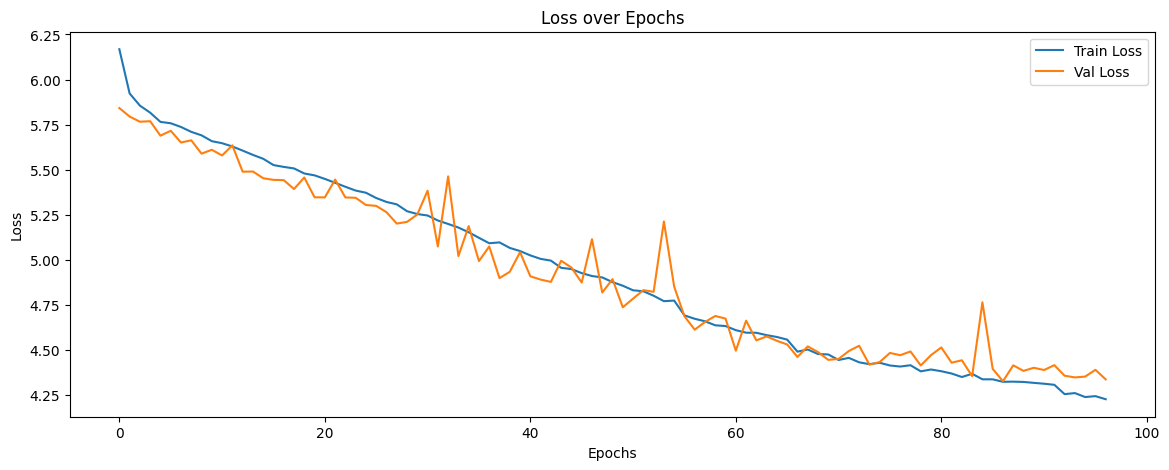

In [41]:
plt.figure(figsize=(14, 5))

plt.plot(_2.history['loss'], label='Train Loss')
plt.plot(_2.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


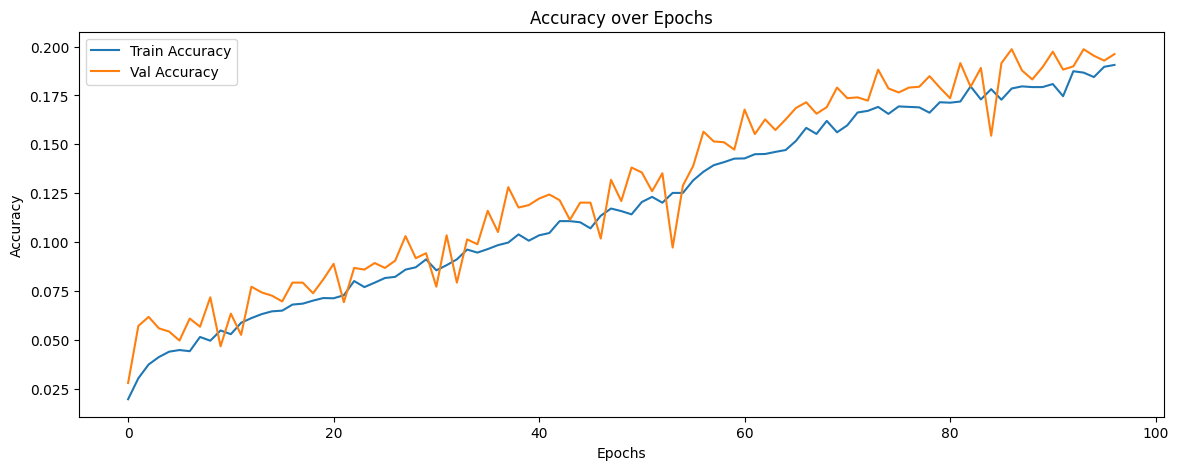

In [42]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.plot(_2.history['accuracy'], label='Train Accuracy')
plt.plot(_2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

In [ ]:

def build_transfg_like(input_shape, num_classes):
    weight_decay = 1e-4

    model = Sequential([
        Input(shape=input_shape),
        augmentation_layer,

        # Block 1
        Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        # MaxPooling2D((2, 2)),  # 128 → 64

        # Block 2
        Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 64 → 32
        Dropout(0.2),

        # Block 3
        Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        #MaxPooling2D((2, 2)),  # 32 → 16

        # Block 4
        Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        #MaxPooling2D((2, 2)),  # 16 → 8
        Dropout(0.2),

        # Block 5
        Conv2D(1024, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(1024, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        #MaxPooling2D((2, 2)),  # 8 → 4

        # Block 6
        Conv2D(1024, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        #MaxPooling2D((2, 2)),  # 4 → 2

        # Block 7
        Conv2D(1024, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 2 → 1
        Dropout(0.2),

        # Final convs without pooling
        Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Dropout(0.2),

        GlobalAveragePooling2D(),

        Dense(1024, activation="relu", kernel_regularizer=l2(weight_decay)),
        Dropout(0.2),

        Dense(512, activation="relu", kernel_regularizer=l2(weight_decay)),
        Dropout(0.2),

        Dense(num_classes, activation="softmax")
    ], name="TransFG_CNN_Large")

    model.summary()
    return model

optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

In [ ]:
# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, f1_score]

model_3 = build_transfg_like(input_shape=input_shape, num_classes=num_classes)

model_3.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
_3 = model_3.fit(
    train_df,
    validation_data=val_df,
    epochs=epochs,  
    callbacks=[lr_reduction, early_stop],
    verbose=1
)

## Model 4

In [44]:


def build_resnet50_with_head(input_shape=input_shape, num_classes=num_classes):

    inputs = Input(shape=input_shape, name="input_layer")
    x = augmentation_layer(inputs)
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=x)
    base_model.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name="ResNet50_CustomHead")
    
    model.summary()
    
    return model


In [45]:
optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, f1_score]

In [46]:
model_4 = build_resnet50_with_head()

model_4.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "ResNet50_CustomHead"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation_layer  │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ augmentation_lay… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c

 Total params: 24,164,170 (92.18 MB)

 Trainable params: 24,111,050 (91.98 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [47]:
# train the model
_4 = model_4.fit(
    train_df,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_df,
    callbacks= [lr_reduction , early_stop]
) 

Epoch 1/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 150s 282ms/step - accuracy: 0.0453 - f1_score: 0.0088 - loss: 5.2763 - val_accuracy: 0.0150 - val_f1_score: 4.7095e-04 - val_loss: 5.3920 - learning_rate: 0.0100
Epoch 2/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 152s 287ms/step - accuracy: 0.1360 - f1_score: 0.0310 - loss: 4.5196 - val_accuracy: 0.1661 - val_f1_score: 0.0476 - val_loss: 4.1533 - learning_rate: 0.0100
Epoch 3/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 154s 290ms/step - accuracy: 0.1757 - f1_score: 0.0588 - loss: 4.1448 - val_accuracy: 0.2241 - val_f1_score: 0.0987 - val_loss: 3.7063 - learning_rate: 0.0100
Epoch 4/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 151s 285ms/step - accuracy: 0.2240 - f1_score: 0.1020 - loss: 3.7779 - val_accuracy: 0.2137 - val_f1_score: 0.1128 - val_loss: 3.7524 - learning_rate: 0.0100
Epoch 5/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 150s 283ms/step - accuracy: 0.2620 - f1_score: 0.1408 - loss: 3.4922 - val_accuracy: 0.2951 - val_f1_score: 0.1816 - val_loss: 3.2427 - learning_rate: 0.0100
E

In [ ]:
y_prob = model_5.predict(val_df, verbose=1)      # shape: (N, 202)
y_pred = np.argmax(y_prob, axis=1)               # predicted class ids
y_true = val['target'].values                        # or:  val_df.df['target'].values

assert len(y_true) == len(y_pred), "mismatch in lengths!"

target_names = label_encoder.classes_

report_df = (
    pd.DataFrame(
        classification_report(
            y_true,
            y_pred,
            target_names=target_names,
            output_dict=True,
            zero_division=0
        )
    )
    .transpose()
    .drop(index=["accuracy", "macro avg", "weighted avg"])
    .sort_values("recall")              
)

pd.set_option("display.max_rows", None)
display(report_df.head(20))               


In [32]:
res50model = Sequential()

res50model.add(Input(shape=(128, 128, 3)))
res50model.add(augmentation_layer)

# Load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # freeze for now
res50model.add(base_model)

res50model.add(GlobalAveragePooling2D())

res50model.add(Dense(2560, activation='relu'))
res50model.add(BatchNormalization())
res50model.add(Dropout(0.4))

res50model.add(Dense(1024, activation='relu'))
res50model.add(BatchNormalization())
res50model.add(Dropout(0.4))

res50model.add(Dense(num_classes, activation='softmax'))

# Compile
optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True, name="SGD")
loss = CategoricalCrossentropy(label_smoothing=0.1, name="smoothed_loss")


categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [
    categorical_accuracy,
    f1_score]


In [33]:
optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, f1_score]
model_5 = res50model
model_5.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [34]:
_5 = model_5.fit(
    train_df,
    batch_size=batch_size,
    epochs=15,
    validation_data=val_df,
    callbacks= [lr_reduction , early_stop])

Epoch 1/15


I0000 00:00:1745406391.368449    4186 cuda_dnn.cc:529] Loaded cuDNN version 90800


525/525 ━━━━━━━━━━━━━━━━━━━━ 97s 177ms/step - accuracy: 0.0178 - f1_score: 0.0079 - loss: 6.1081 - val_accuracy: 0.0217 - val_f1_score: 0.0023 - val_loss: 5.4782 - learning_rate: 0.0100
Epoch 2/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 94s 176ms/step - accuracy: 0.0301 - f1_score: 0.0113 - loss: 5.6678 - val_accuracy: 0.0142 - val_f1_score: 0.0027 - val_loss: 5.8411 - learning_rate: 0.0100
Epoch 3/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 94s 176ms/step - accuracy: 0.0371 - f1_score: 0.0134 - loss: 5.5435 - val_accuracy: 0.0326 - val_f1_score: 0.0074 - val_loss: 5.4182 - learning_rate: 0.0100
Epoch 4/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 94s 177ms/step - accuracy: 0.0462 - f1_score: 0.0140 - loss: 5.4379 - val_accuracy: 0.0422 - val_f1_score: 0.0079 - val_loss: 5.3944 - learning_rate: 0.0100
Epoch 5/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 94s 177ms/step - accuracy: 0.0378 - f1_score: 0.0111 - loss: 5.3850 - val_accuracy: 0.0301 - val_f1_score: 0.0075 - val_loss: 5.3287 - learning_rate: 0.0100
Epoch 6/15
525/525 ━━━━━━━

In [35]:
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile with smaller learning rate
model_5.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True, name="SGD_finetune"),
    loss=loss,
    metrics=metrics
)

# Train further
_5= model_5.fit(
    train_df,
    validation_data=val_df,
    epochs=500,
    callbacks=[lr_reduction, early_stop],
    verbose=1
)

Epoch 1/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 123s 232ms/step - accuracy: 0.0329 - f1_score: 0.0140 - loss: 5.5439 - val_accuracy: 0.0338 - val_f1_score: 0.0057 - val_loss: 5.2958 - learning_rate: 1.0000e-04
Epoch 2/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 123s 231ms/step - accuracy: 0.0408 - f1_score: 0.0146 - loss: 5.1905 - val_accuracy: 0.0409 - val_f1_score: 0.0070 - val_loss: 5.0851 - learning_rate: 1.0000e-04
Epoch 3/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 123s 231ms/step - accuracy: 0.0450 - f1_score: 0.0137 - loss: 5.0691 - val_accuracy: 0.0330 - val_f1_score: 0.0067 - val_loss: 5.1877 - learning_rate: 1.0000e-04
Epoch 4/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 123s 231ms/step - accuracy: 0.0574 - f1_score: 0.0170 - loss: 4.9968 - val_accuracy: 0.0626 - val_f1_score: 0.0210 - val_loss: 4.9335 - learning_rate: 1.0000e-04
Epoch 5/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 123s 231ms/step - accuracy: 0.0606 - f1_score: 0.0195 - loss: 4.9205 - val_accuracy: 0.0689 - val_f1_score: 0.0176 - val_loss: 4.7265 - learning_ra

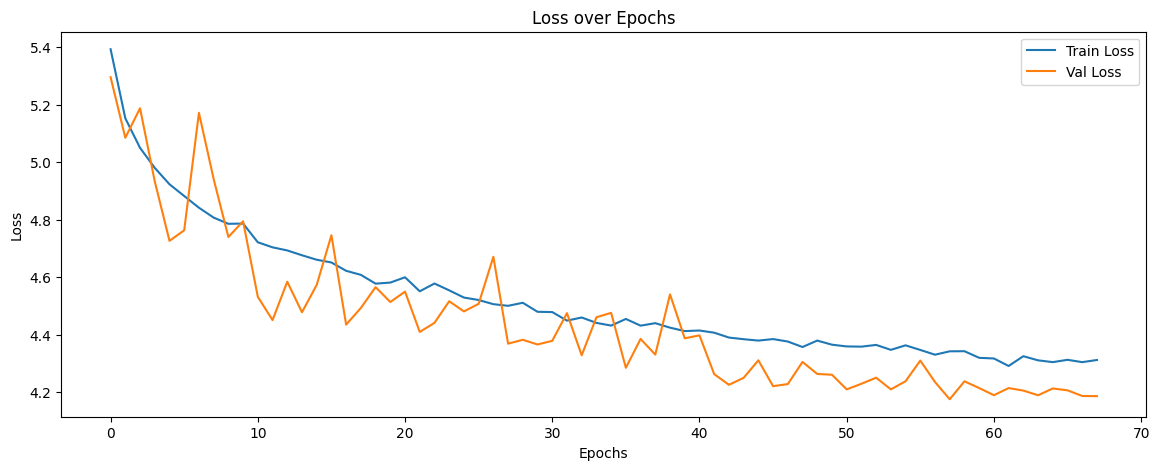

In [36]:

plt.figure(figsize=(14, 5))

# Plot loss
plt.plot(_5.history['loss'], label='Train Loss')
plt.plot(_5.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show() 

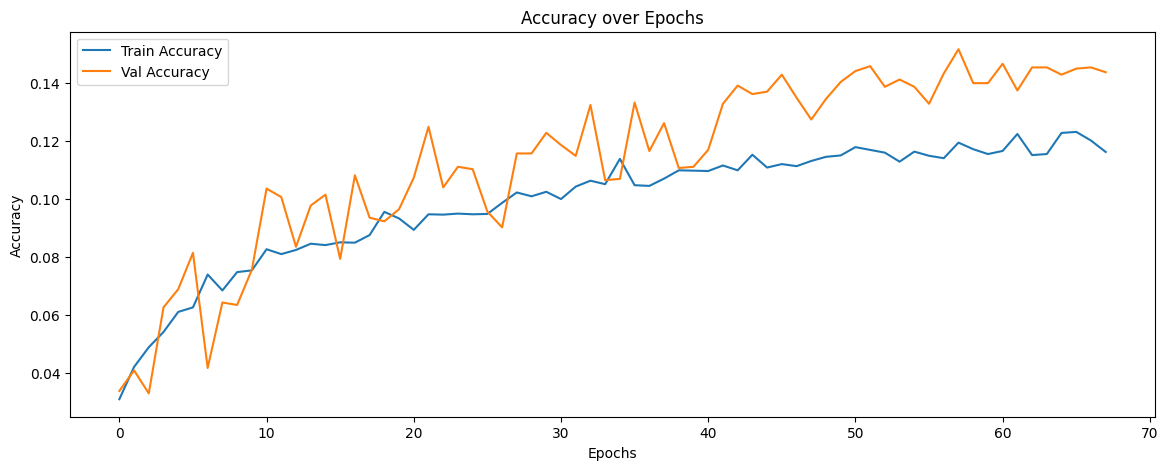

In [37]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.plot(_6.history['accuracy'], label='Train Accuracy')
plt.plot(_6.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [43]:
y_prob = model_5.predict(val_df, verbose=1)      # shape: (N, 202)
y_pred = np.argmax(y_prob, axis=1)               # predicted class ids

NameError: name 'model_4' is not defined

In [39]:
y_true = val['target'].values                        # or:  val_df.df['target'].values

assert len(y_true) == len(y_pred), "mismatch in lengths!"

In [42]:
target_names = label_encoder.classes_

report_df = (
    pd.DataFrame(
        classification_report(
            y_true,
            y_pred,
            target_names=target_names,
            output_dict=True,
            zero_division=0
        )
    )
    .transpose()
    .drop(index=["accuracy", "macro avg", "weighted avg"])
    .sort_values("recall")              
)

pd.set_option("display.max_rows", None)
display(report_df.head(20))               


,precision,recall,f1-score,support
accipitridae,0.0,0.0,0.0,24.0
acipenseridae,0.0,0.0,0.0,18.0
acroporidae,0.0,0.0,0.0,42.0
agamidae,0.0,0.0,0.0,12.0
agariciidae,0.0,0.0,0.0,24.0
albulidae,0.0,0.0,0.0,6.0
alcedinidae,0.0,0.0,0.0,6.0
alligatoridae,0.0,0.0,0.0,6.0
alopiidae,0.0,0.0,0.0,12.0
ambystomatidae,0.0,0.0,0.0,12.0


## Eficient Net V2S

In [ ]:
def build_efficientnetv2s_model(input_shape=input_shape, num_classes=num_classes):
    inputs = Input(shape=input_shape, name="input_layer")
    x = augmentation_layer(inputs)
    base_model = EfficientNetV2S(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        include_preprocessing=True
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output, name="EfficientNetV2S_Custom")
    return model


In [ ]:
effnet = build_efficientnetv2s_model(input_shape=input_shape, num_classes=num_classes)
# effnet.summary()

metrics = [
    CategoricalAccuracy(name="accuracy"),
    TopKCategoricalAccuracy(k=5, name="top_5_accuracy"),
    F1Score(name="f1_score", average="macro")
]

effnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(),
    metrics=metrics)


Model: "EfficientNetV2S_Custom"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_10        │ (None, 128, 128,  │          0 │ input_layer_19[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        648 │ rescaling_10[0][… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64,    │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64,    │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 64, 64,    │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 64, 64,    │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 64, 64,    │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 64, 64,    │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 64, 64,    │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 64, 64,    │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b

 Total params: 20,590,122 (78.55 MB)

 Trainable params: 20,436,250 (77.96 MB)

 Non-trainable params: 153,872 (601.06 KB)

In [ ]:
checkpoint_cb = ModelCheckpoint(
    filepath='efficientnetv2s_best_model.weights.h5',  # keras or .h5
    monitor='val_loss',                    
    save_best_only=True,
    save_weights_only=True,                   # True = only weights, False = full model
    verbose=1
)


In [105]:
_6 = effnet.fit(
    train_df,
    validation_data=val_df,
    epochs=200,
    callbacks=[early_stop, lr_reduction, checkpoint_cb],
    verbose=1
)

Epoch 1/200
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0335 - f1_score: 0.0111 - loss: 5.2230 - top_5_accuracy: 0.0853
Epoch 1: val_loss improved from inf to 4.46289, saving model to efficientnetv2s_best_model.weights.h5
516/516 ━━━━━━━━━━━━━━━━━━━━ 664s 1s/step - accuracy: 0.0335 - f1_score: 0.0111 - loss: 5.2225 - top_5_accuracy: 0.0854 - val_accuracy: 0.1501 - val_f1_score: 0.0432 - val_loss: 4.4629 - val_top_5_accuracy: 0.3189 - learning_rate: 1.0000e-04
Epoch 2/200
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1543 - f1_score: 0.0461 - loss: 4.2702 - top_5_accuracy: 0.3371
Epoch 2: val_loss improved from 4.46289 to 3.71196, saving model to efficientnetv2s_best_model.weights.h5
516/516 ━━━━━━━━━━━━━━━━━━━━ 661s 1s/step - accuracy: 0.1543 - f1_score: 0.0461 - loss: 4.2699 - top_5_accuracy: 0.3372 - val_accuracy: 0.2375 - val_f1_score: 0.0966 - val_loss: 3.7120 - val_top_5_accuracy: 0.4601 - learning_rate: 1.0000e-04
Epoch 3/200
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/s

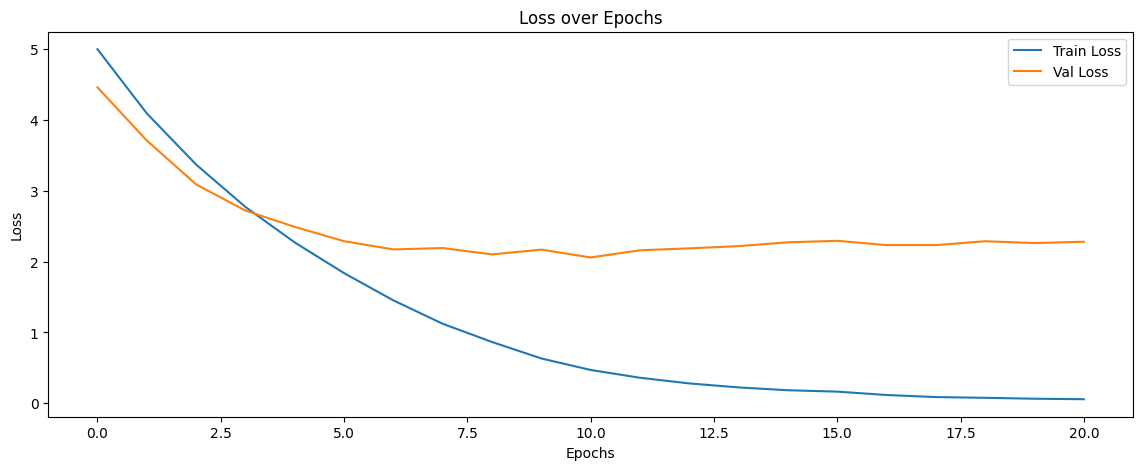

In [106]:

plt.figure(figsize=(14, 5))

# Plot loss
plt.plot(_6.history['loss'], label='Train Loss')
plt.plot(_6.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show() 

In [107]:
y_prob = effnet.predict(val_df, verbose=1)      # shape: (N, 202)
y_pred = np.argmax(y_prob, axis=1)               # predicted class ids

148/148 ━━━━━━━━━━━━━━━━━━━━ 30s 194ms/step


In [108]:
y_true = val['target'].values                    

assert len(y_true) == len(y_pred), "mismatch in lengths!"

In [110]:
target_names = label_encoder.classes_

report_df = (
    pd.DataFrame(
        classification_report(
            y_true,
            y_pred,
            target_names=target_names,
            output_dict=True,
            zero_division=0
        )
    )
    .transpose()
    .drop(index=["accuracy", "macro avg", "weighted avg"])
    .sort_values("recall")              
)

pd.set_option("display.max_rows", None)
display(report_df)               


,precision,recall,f1-score,support
accipitridae,0.000000,0.000000,0.000000,23.0
acipenseridae,0.000000,0.000000,0.000000,18.0
agamidae,0.000000,0.000000,0.000000,12.0
agariciidae,0.000000,0.000000,0.000000,24.0
alcedinidae,0.000000,0.000000,0.000000,6.0
albulidae,0.000000,0.000000,0.000000,6.0
alligatoridae,0.000000,0.000000,0.000000,6.0
alopiidae,0.000000,0.000000,0.000000,12.0
arthroleptidae,0.000000,0.000000,0.000000,6.0
ambystomatidae,0.000000,0.000000,0.000000,10.0


Let's add some weights to the classes that are having trouble in the predictions

In [ ]:
# adding bias as seen in the tensorflow website https://www.tensorflow.org/tutorials/structured_data/imbalanced_data


# Count images per class
counts = clean_metadata['target'].value_counts().sort_index()  # must be sorted to match class indices
total = np.sum(counts)

# Compute log priors
initial_bias = np.log(counts / total)


In [ ]:
def build_efficientnetv2s_model(input_shape=input_shape, num_classes=num_classes):
    inputs = Input(shape=input_shape, name="input_layer")
    x = augmentation_layer(inputs)
    base_model = EfficientNetV2S(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        include_preprocessing=True
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation="softmax",bias_initializer= Constant(initial_bias))(x)

    model = Model(inputs=base_model.input, outputs=output, name="EfficientNetV2S_Custom")
    return model


In [ ]:
effnet_v2 = build_efficientnetv2s_model(input_shape=input_shape, num_classes=num_classes)
#effnet_v2.summary()

metrics = [
    CategoricalAccuracy(name="accuracy"),
    TopKCategoricalAccuracy(k=5, name="top_5_accuracy"),
    F1Score(name="f1_score", average="macro")
]

effnet_v2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(),
    metrics=metrics)


Model: "EfficientNetV2S_Custom"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_14        │ (None, 128, 128,  │          0 │ input_layer_23[0… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        648 │ rescaling_14[0][… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │      5,184 │ stem_activation[… │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64,    │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64,    │          0 │ block1a_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, 64, 64,    │          0 │ block1a_project_… │
│                     │ 24)               │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 64, 64,    │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 64, 64,    │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 64, 64,    │          0 │ block1b_project_… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 64, 64,    │          0 │ block1b_project_… │
│ (Dropout)           │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 64, 64,    │          0 │ block1b_drop[0][… │
│                     │ 24)               │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b

 Total params: 20,590,122 (78.55 MB)

 Trainable params: 20,436,250 (77.96 MB)

 Non-trainable params: 153,872 (601.06 KB)

In [136]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0, verbose = 1)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4, restore_best_weights = True)

In [ ]:
checkpoint_cb = ModelCheckpoint(
    filepath='efficientnetv2s_best_model.weights.h5',  # keras or .h5
    monitor='val_loss',                    
    save_best_only=True,
    save_weights_only=True,                   # True = only weights, False = full model
    verbose=1
)


In [138]:
_7 = effnet_v2.fit(
    train_df,
    validation_data=val_df,
    epochs=200,
    callbacks=[early_stop, lr_reduction, checkpoint_cb],
    verbose=1,
    class_weight=class_weights_dict 
)

Epoch 1/200


/home/ruben/anaconda3/envs/DeepLearn/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0313 - f1_score: 0.0040 - loss: 5.5665 - top_5_accuracy: 0.1177
Epoch 1: val_loss improved from inf to 4.74313, saving model to efficientnetv2s_best_model.weights.h5
516/516 ━━━━━━━━━━━━━━━━━━━━ 674s 1s/step - accuracy: 0.0313 - f1_score: 0.0040 - loss: 5.5663 - top_5_accuracy: 0.1177 - val_accuracy: 0.0916 - val_f1_score: 0.0278 - val_loss: 4.7431 - val_top_5_accuracy: 0.2180 - learning_rate: 1.0000e-04
Epoch 2/200
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0887 - f1_score: 0.0446 - loss: 4.9148 - top_5_accuracy: 0.2271
Epoch 2: val_loss improved from 4.74313 to 4.18441, saving model to efficientnetv2s_best_model.weights.h5
516/516 ━━━━━━━━━━━━━━━━━━━━ 672s 1s/step - accuracy: 0.0887 - f1_score: 0.0446 - loss: 4.9145 - top_5_accuracy: 0.2271 - val_accuracy: 0.1624 - val_f1_score: 0.1138 - val_loss: 4.1844 - val_top_5_accuracy: 0.3533 - learning_rate: 1.0000e-04
Epoch 3/200
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accura

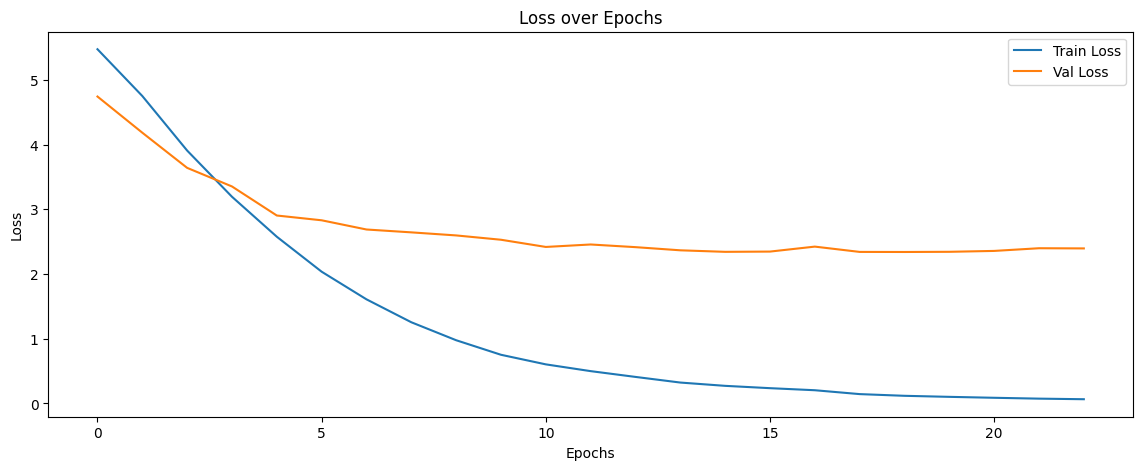

In [143]:

plt.figure(figsize=(14, 5))

# Plot loss
plt.plot(_7.history['loss'], label='Train Loss')
plt.plot(_7.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show() 

In [145]:
y_prob = effnet_v2.predict(test_df, verbose=1)      # shape: (N, 202)
y_pred = np.argmax(y_prob, axis=1)               # predicted class ids

74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step


In [146]:
y_true = test['target'].values                    

assert len(y_true) == len(y_pred), "mismatch in lengths!"

In [147]:
report = classification_report(
    y_true,
    y_pred,
    target_names=label_encoder.classes_,
    output_dict=True,
    zero_division=0
)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Calculate top-5 accuracy separately
top5_acc = top_k_accuracy_score(y_true, y_prob, k=5)

# Keep only 'f1-score' column
report_df = report_df[['f1-score']]  

# Insert top-5 manually
report_df.loc['top_5_accuracy'] = [top5_acc]

# Insert overall accuracy manually (global accuracy)
overall_accuracy = (y_true == y_pred).mean()
report_df.loc['accuracy'] = [overall_accuracy]

# Clean display
pd.set_option('display.max_rows', None)
display(report_df)

,f1-score
accipitridae,0.222222
acipenseridae,0.400000
acroporidae,0.648649
agamidae,0.615385
agariciidae,0.666667
albulidae,0.000000
alcedinidae,0.666667
alligatoridae,0.333333
alopiidae,0.333333
ambystomatidae,0.222222


In [144]:
# target_names = label_encoder.classes_

# report_df = (
#     pd.DataFrame(
#         classification_report(
#             y_true,
#             y_pred,
#             target_names=target_names,
#             output_dict=True,
#             zero_division=0
#         )
#     )
#     .transpose()
#     .drop(index=["accuracy", "macro avg", "weighted avg"])
#     .sort_values("recall")              
# )

# pd.set_option("display.max_rows", None)
# display(report_df.head(202))               


In [152]:
effnet_v3 = build_efficientnetv2s_model(input_shape=input_shape, num_classes=num_classes)
#effnet_v2.summary()

metrics = [
    CategoricalAccuracy(name="accuracy"),
    TopKCategoricalAccuracy(k=5, name="top_5_accuracy"),
    F1Score(name="f1_score", average="macro")
]

effnet_v3.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(),
    metrics=metrics)


In [153]:
_7 = effnet_v3.fit(
    train_df,
    validation_data=val_df,
    epochs=200,
    callbacks=[early_stop, lr_reduction, checkpoint_cb],
    verbose=1,
    #class_weight=class_weights_dict 
)

Epoch 1/200
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0483 - f1_score: 0.0064 - loss: 4.9939 - top_5_accuracy: 0.1544
Epoch 1: val_loss did not improve from 2.34097
516/516 ━━━━━━━━━━━━━━━━━━━━ 656s 1s/step - accuracy: 0.0484 - f1_score: 0.0064 - loss: 4.9936 - top_5_accuracy: 0.1545 - val_accuracy: 0.1421 - val_f1_score: 0.0265 - val_loss: 4.3960 - val_top_5_accuracy: 0.2786 - learning_rate: 1.0000e-04
Epoch 2/200
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1593 - f1_score: 0.0336 - loss: 4.2365 - top_5_accuracy: 0.3118
Epoch 2: val_loss did not improve from 2.34097
516/516 ━━━━━━━━━━━━━━━━━━━━ 653s 1s/step - accuracy: 0.1593 - f1_score: 0.0336 - loss: 4.2362 - top_5_accuracy: 0.3118 - val_accuracy: 0.2180 - val_f1_score: 0.0818 - val_loss: 3.6764 - val_top_5_accuracy: 0.4432 - learning_rate: 1.0000e-04
Epoch 3/200
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2481 - f1_score: 0.1012 - loss: 3.5056 - top_5_accuracy: 0.4785
Epoch 3: val_loss did not improv

In [156]:
env3_eva = effnet_v3.evaluate(val_df, verbose=1)

148/148 ━━━━━━━━━━━━━━━━━━━━ 32s 208ms/step - accuracy: 0.5348 - f1_score: 0.4425 - loss: 2.1870 - top_5_accuracy: 0.7528


In [169]:
env3_eva2 = effnet_v3.evaluate(test_df, verbose=1)
env3_eva2

74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 206ms/step - accuracy: 0.5408 - f1_score: 0.3702 - loss: 2.1630 - top_5_accuracy: 0.7591


[2.1730360984802246,
 0.5402883887290955,
 0.7548770308494568,
 0.47866255044937134]

In [160]:
env3_eva

[2.089853048324585, 0.551314651966095, 0.7625105977058411, 0.5134905576705933]

In [162]:
y_prob = effnet_v3.predict(val_df, verbose=1)      # shape: (N, 202)
y_pred = np.argmax(y_prob, axis=1)               # predicted class ids

148/148 ━━━━━━━━━━━━━━━━━━━━ 31s 197ms/step


In [164]:
y_true = val['target'].values                    

assert len(y_true) == len(y_pred), "mismatch in lengths!"

In [166]:
# report = classification_report(
#     y_true,
#     y_pred,
#     target_names=label_encoder.classes_,
#     output_dict=True,
#     zero_division=0
# )

# # Convert to DataFrame
# report_df = pd.DataFrame(report).transpose()

# # Calculate top-5 accuracy separately
# top5_acc = top_k_accuracy_score(y_true, y_prob, k=5)

# # Keep only 'f1-score' column
# report_df = report_df[['f1-score']]  

# # Insert top-5 manually
# report_df.loc['top_5_accuracy'] = [top5_acc]

# # Insert overall accuracy manually (global accuracy)
# overall_accuracy = (y_true == y_pred).mean()
# report_df.loc['accuracy'] = [overall_accuracy]

# # Clean display
# pd.set_option('display.max_rows', None)
# display(report_df)

In [167]:
target_names = label_encoder.classes_

report_df = (
    pd.DataFrame(
        classification_report(
            y_true,
            y_pred,
            target_names=target_names,
            output_dict=True,
            zero_division=0
        )
    )
    .transpose()
    .drop(index=["accuracy", "macro avg", "weighted avg"])
    .sort_values("recall")              
)

pd.set_option("display.max_rows", None)
display(report_df.head(202))               


,precision,recall,f1-score,support
accipitridae,0.000000,0.000000,0.000000,23.0
acipenseridae,0.000000,0.000000,0.000000,18.0
acroporidae,0.000000,0.000000,0.000000,42.0
agariciidae,0.000000,0.000000,0.000000,24.0
alcedinidae,0.000000,0.000000,0.000000,6.0
albulidae,0.000000,0.000000,0.000000,6.0
alligatoridae,0.000000,0.000000,0.000000,6.0
alopiidae,0.000000,0.000000,0.000000,12.0
arthroleptidae,0.000000,0.000000,0.000000,6.0
ambystomatidae,0.000000,0.000000,0.000000,10.0
